<a href="https://colab.research.google.com/github/onertartan/recommender-systems-board-games/blob/main/explanatory_1_user_based_collaborative_filtering_data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# USER BASED COLLABORATIVE FILTERING

Original Dataset is taken from <a>https://www.kaggle.com/datasets/jvanelteren/boardgamegeek-reviews</a> <br>
Download **bgg-19m-reviews.zip** and unzip file.
This dataset contains approximately 19 million ratings with reviews for 21839 games.

In [ ]:
# File link: https://drive.google.com/file/d/1cLU3rIeGB0s112LZ0AUdd_3Ei11q46Ap/view?usp=drive_link
!gdown 1cLU3rIeGB0s112LZ0AUdd_3Ei11q46Ap&confirm=t

Import packages and load data.

In [2]:
import numpy as np
import pandas as pd
from functools import partial
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from zipfile import ZipFile
import random
#Download original dataset
with ZipFile("bgg-19m-reviews.zip") as zipFile:
    zipFile.extractall()

## 1- EXAMINE DATA

In [3]:
import pandas as pd
df_ratings=pd.read_csv("bgg-19m-reviews.csv")
df_ratings.head(3)

,Unnamed: 0,user,rating,comment,ID,name
0,0,Torsten,10.0,NaN,30549,Pandemic
1,1,mitnachtKAUBO-I,10.0,Hands down my favorite new game of BGG CON 200...,30549,Pandemic
2,2,avlawn,10.0,I tend to either love or easily tire of co-op ...,30549,Pandemic


We can exclude reviews to reduce memory and select other columns.

In [4]:
df_ratings.drop(columns=["comment","Unnamed: 0"],inplace=True)

Let's rename columns for clearity.

In [5]:
df_ratings.rename(columns={"user":"user_name","ID":"game_id","name":"game_name"},inplace=True)
df_ratings.head(2)

,user_name,rating,game_id,game_name
0,Torsten,10.0,30549,Pandemic
1,mitnachtKAUBO-I,10.0,30549,Pandemic


Check dtypes

In [6]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18964807 entries, 0 to 18964806
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   user_name  object 
 1   rating     float64
 2   game_id    int64  
 3   game_name  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 578.8+ MB


Check number of users, games game names and unique values of ratings.

In [7]:
print("Total number of ratings       :",len(df_ratings))
print("Number of users               :",df_ratings["user_name"].nunique())
print("Number of games               :",df_ratings["game_id"].nunique())
print("Number of unique game names  :",df_ratings["game_name"].nunique())
print("Number of unique rating values:",df_ratings["rating"].nunique())

Total number of ratings       : 18964807
Number of users               : 412815
Number of games               : 21839
Number of unique game names  : 21440
Number of unique rating values: 10759


We can see that some games have same names.<br>
Also note that rating values have 10759 unique values.<br>
Now let's check the "rating" column.

In [8]:
df_ratings["rating"].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
rating,18964807.0,7.081849,1.595931,1.401300e-45,6.0,7.0,8.0,10.0


Ratings are decimal and need to be rounded.

Check missing values

In [9]:
df_ratings.isna().sum()

user_name    66
rating        0
game_id       0
game_name     0
dtype: int64

There are 66 missing values in the column **user**.

In [10]:
print(f"Number of unique ratings {df_ratings['rating'].nunique()}")

Number of unique ratings 10759


## 2- DATA PREPROCESSING

Based on the examination in the previous step, we have to preprocess data.<br>
First let's round **rating**s and convert to int8 dtype for memory efficiency.

In [11]:
df_ratings["rating"]=round(df_ratings["rating"]).astype("int8")
print("Number of unique values of ratings",df_ratings["rating"].nunique() )
print("Unique values of ratings",df_ratings["rating"].unique())

Number of unique values of ratings 11
Unique values of ratings [10  9  8  7  6  5  4  3  2  1  0]


IDs can be converted to uint32 to reduce data size.

In [12]:
df_ratings["game_id"]=df_ratings["game_id"].astype("uint32")

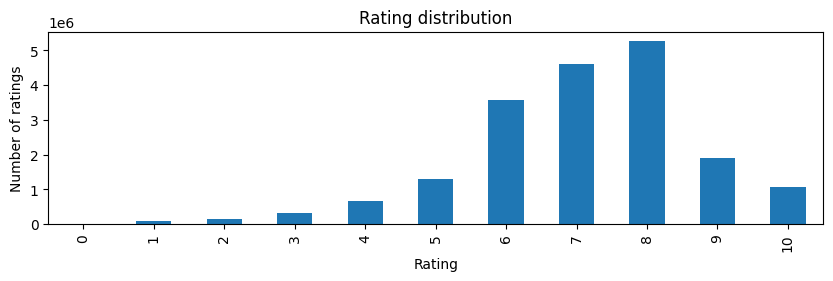

In [ ]:
ax = df_ratings["rating"].value_counts().sort_index().plot(kind="bar",title="Rating distribution",xlabel="Rating",ylabel="Number of ratings",figsize=(10,2.5))

Check the new data types

In [13]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18964807 entries, 0 to 18964806
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   user_name  object
 1   rating     int8  
 2   game_id    uint32
 3   game_name  object
dtypes: int8(1), object(2), uint32(1)
memory usage: 379.8+ MB


## 3-1 DATA CLEANING

3.1  Cleaning missing values <br>
3.2  Reducing games with few ratings (optional step. We will not exclude any games.) <br>
3.3  Removing users with few ratings <br>

### 3-1 Cleaning missing values

Dataframe had missing values in "user" column.

In [14]:
df_ratings.isna().sum()

user_name    66
rating        0
game_id       0
game_name     0
dtype: int64

Let's drop the missing users.

In [15]:
df_ratings.dropna(subset="user_name",inplace=True,axis=0)

Check missing values again.

In [16]:
df_ratings.isna().sum().any()

False

We can drop zero ratings.

In [17]:
index_zeros= df_ratings[df_ratings["rating"]==0].index
df_ratings.drop(index_zeros , inplace=True,axis=0)

## 3-2 Reducing ratings dataframe - removing games with few ratings

* In this optional step, we can filter out games with the number of ratings less than a threshold.
* In content-based collaborative filtering,  we will not exclude any game.
* So this step is given for demonstration of this optional process.Therefore, we choose threshold as 1 to include all games.
* We will use the same helper function **filter_by_threshold** in the next step to filter out the users with few ratings.

> Girintili blok



In [18]:
def filter_by_threshold(df_ratings,filter_col,threshold):
  """
  Filters df filter_col according to the number of ratings (threshold)
  Reduces rows based on 'user_name'  or 'game_id'.
  """
  df_count = df_ratings[filter_col].value_counts().reset_index()
  count_col = "total_num_ratings_for_"+filter_col
  df_count.columns=[filter_col, count_col]
  # Filter games with more than number of ratings greater than threshold
  df_frequent = df_count[df_count[count_col] >= threshold]
  # Merge the original DataFrame with the filtered games
  result_df = pd.merge(df_frequent , df_ratings, on = filter_col)
  return result_df

In [19]:
def plot_thresholds(df,filter_col,y_label,thresholds):
    numbers_of_filter_col=[]
    for threshold in thresholds:
        result_df = filter_by_threshold(df,filter_col,threshold)
        numbers_of_filter_col.append(result_df[filter_col].nunique())
    plt.figure(figsize=(10,5 ))
    plt.plot(thresholds,numbers_of_filter_col,marker="o")
    plt.xticks(thresholds)
    plt.xlabel("Threshold (minimum number of ratings)")
    plt.ylabel(f"{y_label}")
    plt.title(f"{y_label} with number of ratings> threshold")
    plt.show()

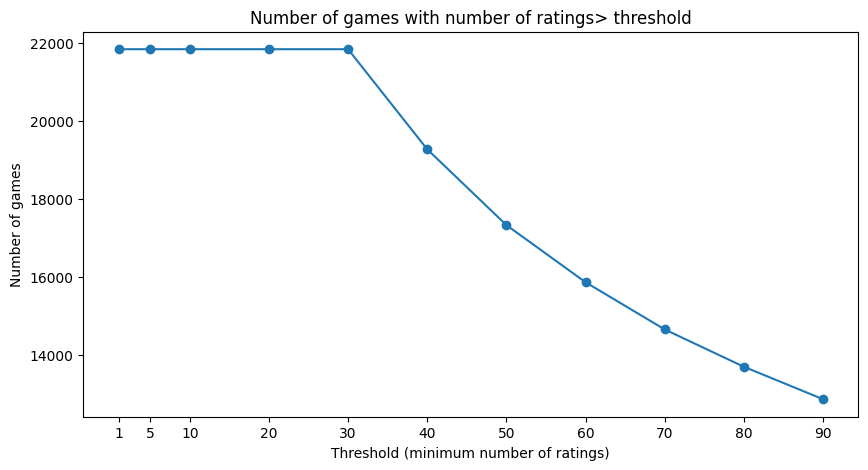

In [ ]:
thresholds=[1,5]
thresholds.extend(list(range(10,100,10)))
plot_thresholds(df_ratings,"game_id","Number of games",thresholds)

As the minimum number of ratings increases the number of games decrease.  <br> If we want to exclude games which are rated less than a number of times we can uncomment and run the cell below.

In [20]:
# OPTIONAL STEP: threshold is 1 for demonstration (we don't exclude any game)
threshold_num_ratings_for_game = 1
print(f"Before filtering, the  number of games: {df_ratings['game_id'].nunique()}")
df_ratings=filter_by_threshold(df_ratings,filter_col="game_id",threshold=threshold_num_ratings_for_game)
print(f"After filtering, the number of games: {df_ratings['game_id'].nunique()}")

Before filtering, the  number of games: 21839
After filtering, the number of games: 21839


## 3-3 Reducing ratings dataframe - removing users with few ratings

We will filter users with the number of ratings less than a threshold.

Let's check initial number of unique users.

In [21]:
df_ratings["user_name"].nunique()

412815

Users with few ratings can be removed. Let's check the number of users for different thresholds(number of ratings).

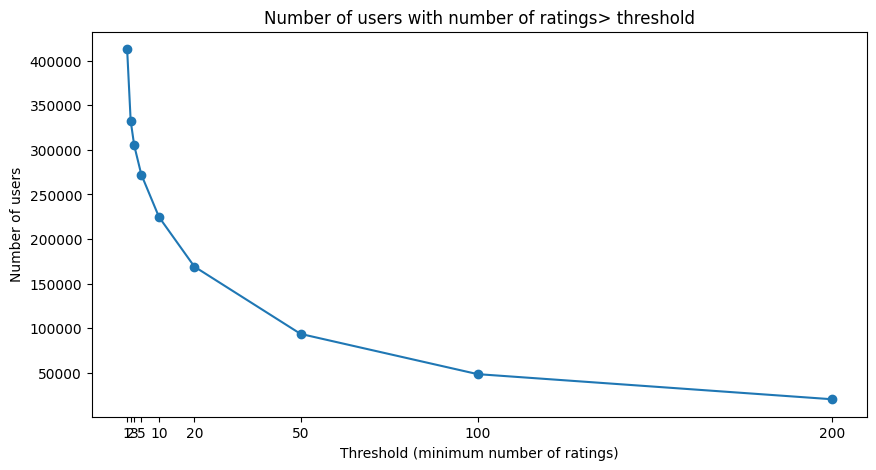

In [ ]:
thresholds=[1,2,3,5,10,20,50,100,200]
plot_thresholds(df_ratings,filter_col="user_name", y_label="Number of users", thresholds=thresholds)

Choosing threshold as **10**, we can remove users whose number of ratings are less than threshold.<br>(Note in recommendation we will use another third **threshold for the number of common games** with the target user.

In [23]:
threshold_num_games_rated = 10
print(f"Before filtering, the  number of users: {df_ratings['user_name'].nunique()}")
df_ratings_10=filter_by_threshold(df_ratings,filter_col="user_name",threshold=threshold_num_games_rated)
print(f"After filtering, the number of users: {df_ratings_10['user_name'].nunique()}")

Before filtering, the  number of users: 412815
After filtering, the number of users: 224662


Let's check df_ratings after removing less active users.

In [ ]:
df_ratings_10.head(2)

,user_name,total_num_ratings_for_user_name,game_id,total_num_ratings_for_game_id,rating,game_name
0,oldgoat3769967,6471,30549,108971,8,Pandemic
1,oldgoat3769967,6471,822,108880,7,Carcassonne


In [ ]:
df_ratings_10.tail(2)

,user_name,total_num_ratings_for_user_name,game_id,total_num_ratings_for_game_id,rating,game_name
18393098,Karatevater,10,172047,3569,9,The Others
18393099,Karatevater,10,174805,385,6,Champions of Hara


In [ ]:
df_ratings_10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18393100 entries, 0 to 18393099
Data columns (total 6 columns):
 #   Column                           Dtype 
---  ------                           ----- 
 0   user_name                        object
 1   total_num_ratings_for_user_name  int64 
 2   game_id                          int64 
 3   total_num_ratings_for_game_id    int64 
 4   rating                           int8  
 5   game_name                        object
dtypes: int64(3), int8(1), object(2)
memory usage: 859.5+ MB


## Processing To Reduce Memory Size

1- We can drop **total_num_ratings_for_user_name** and	**total_num_ratings_for_game_id** columns for memory efficiency in deployment.

In [ ]:
df_ratings_10.drop(columns=["total_num_ratings_for_user_name","total_num_ratings_for_game_id"],inplace=True)
df_ratings_10.head(2)

,user_name,game_id,rating,game_name
0,oldgoat3769967,30549,8,Pandemic
1,oldgoat3769967,822,7,Carcassonne


2- We can also drop **game_name** column for memory efficiency.<br>
However, we have to create a dictionary df to access to game names later using game ids. <br> Let's call this dictionary df as **df_id2game** whose **keys are game ids and values are game names**.

In [ ]:
df_id2game = df_ratings[["game_id","game_name"]]
df_id2game.set_index("game_id",inplace=True)
df_id2game = pd.DataFrame(df_id2game.to_dict())
df_id2game.index.name="game_id"
df_id2game.index = df_id2game.index.astype("uint32")
df_id2game.head(2)

,game_name
game_id,
1,Die Macher
2,Dragonmaster


In [ ]:
df_id2game.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 21839 entries, 1 to 350992
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   game_name  21839 non-null  object
dtypes: object(1)
memory usage: 341.2+ KB


Once we have a **game2id** dictionary dataframe we can drop **game_name** in df_ratings.

In [ ]:
df_ratings_10.drop(columns=["game_name"],inplace=True)

We can simply create the opposite **df_game2id** dictionary: **keys are game names** and **values are game ids**.

In [ ]:
df_game2id = df_id2game.reset_index().set_index("game_name")
df_game2id["game_id"] = df_game2id["game_id"].astype("uint32")
df_game2id.head()

,game_id
game_name,
Die Macher,1
Dragonmaster,2
Samurai,3
Tal der Könige,4
Acquire,5


3- We will **drop user_name column** to reduce memory.<br> However, the original dataset does not contain int user ids, but **we can create integer user ids**. <br> In short; to access user name using user id, we create dictionary dataframe mapping user ids to user names.<br>To access to user_name using user_id we create the reversed dictionary dataframe. **df_user2id** dictionary where keys are user names and values are user ids.

In [ ]:
df_user2id = pd.DataFrame(index = df_ratings_10["user_name"].unique())
df_user2id.index.name="user_name"
df_user2id["user_id"]=range(1, len(df_user2id) + 1)
df_user2id["user_id"] = df_user2id["user_id"].astype("uint32")
df_user2id.head()

,user_id
user_name,
oldgoat3769967,1
warta,2
leffe dubbel,3
TomVasel,4
Doel,5


Let's create the reversed dictionary dataframe, **df_id2user**, where **keys represent user names and values represent user ids**.

In [ ]:
df_id2user = df_user2id.reset_index().set_index("user_id")
df_id2user.index=df_id2user.index.astype("uint32")
df_id2user.head()

,user_name
user_id,
1,oldgoat3769967
2,warta
3,leffe dubbel
4,TomVasel
5,Doel


Now, we can **add user_id column** to df_ratings and then **drop user_name column**. This will reduce memory of df_ratings.<br>
Later, we can access the user name from user id using the dictionary we created above.

In [ ]:
df_ratings_10["user_id"]= df_ratings_10["user_name"].map(df_user2id["user_id"].to_dict())
df_ratings_10.head(3)

,user_name,game_id,rating,user_id
0,oldgoat3769967,30549,8,1
1,oldgoat3769967,822,7,1
2,oldgoat3769967,13,7,1


Now we can drop user_name and set index as user id for memory efficiency.

In [ ]:
df_ratings_10.drop("user_name",inplace=True,axis=1)
df_ratings_10.set_index("user_id",inplace=True)
df_ratings_10.head()

,game_id,rating
user_id,,
1,30549,8
1,822,7
1,13,7
1,68448,8
1,36218,7


We can set data type of index  as uint32 to reduce memory.

In [ ]:
df_ratings_10["game_id"] = df_ratings_10["game_id"].astype("int32")
df_ratings_10.index = df_ratings_10.index.astype("uint32")

In [ ]:
df_ratings_10.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 18393100 entries, 1 to 224662
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   game_id  int32
 1   rating   int8 
dtypes: int32(1), int8(1)
memory usage: 228.0 MB


## SAVING DATA FOR DEPLOYMENT

Finally, we can save **df_ratings** and dictionaries **df_id2user**, **df_user2id**, **df_id2game**, **df_game2_id**.

In [ ]:
df_ratings_10.to_csv("df_ratings_10.csv")
df_user2id.to_csv("df_user2id.csv")
df_id2user.to_csv("df_id2user.csv")
df_id2game.to_csv("df_id2game.csv")
df_game2id.to_csv("df_game2id.csv")